# Find mapping for reservoir with classification problems

This notebook take an input dataset for regression problem and binarize the input to be fed to an AMN reservoir. The code make use of RandomForestRegressor to rank the features (feature_importance) and find the mapping to the reservoir input.

## Utilities

In [42]:
# Refactoring the original script into functions and a main block

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_random_points(n_points=132, seed=42):
    np.random.seed(seed)  # For reproducibility
    x1 = np.random.rand(n_points)
    x2 = np.random.rand(n_points)
    return x1, x2

def generate_and_condition(x1, x2):
    labels = np.where((x1 > 0.5) & (x2 > 0.5), 1, 0)
    return labels

def generate_or_condition(x1, x2):
    labels = np.where((x1 > 0.5) | (x2 > 0.5), 1, 0)
    return labels

def generate_linear_condition(x1, x2):
    labels = np.where(x2 > x1, 1, 0)
    return labels

def generate_triangle_condition(x1, x2):
    x1, x2 = 1 - x1, 1 - x2
    y_line1 = 1/3 + (0.5 - 1/3) * x1 / 0.5  # First line equation
    y_line2 = 1 - x1  # Second line equation
    labels = np.where((x2 > y_line1) & (x2 > y_line2), 1, 0)
    return labels
    
def generate_xor_condition(x1, x2):
    labels = np.where((x1 > 0.5) ^ (x2 > 0.5), 1, 0)
    return labels

def generate_checkerboard(x1, x2, divisions=3):
    x1_bin = np.floor(x1 * divisions)
    x2_bin = np.floor(x2 * divisions)
    labels = np.where((x1_bin + x2_bin) % 2 == 0, 1, 0)
    return labels

def generate_circle_condition(x1, x2, center=(0.5, 0.5), radius=0.3):
    distance = np.sqrt((x1 - center[0]) ** 2 + (x2 - center[1]) ** 2)
    labels = np.where(distance <= radius, 1, 0)
    return labels

def generate_sine_wave_condition(x1, x2, amplitude=0.5, frequency=2*np.pi):
    sine_wave = amplitude * np.sin(frequency * x1) + 0.5
    labels = np.where(x2 > sine_wave, 1, 0)
    return labels

def generate_concentric_condition(x1, x2, center=(0.5, 0.5), radii=(0.15, 0.35)):
    distance = np.sqrt((x1 - center[0]) ** 2 + (x2 - center[1]) ** 2)
    labels = np.where((distance <= radii[0]) | (distance > radii[1]), 1, 0)
    return labels

def generate_two_dots_condition(x1, x2, center1=(0.75, 0.75), center2=(0.25, 0.25), threshold=0.2):
    distances_center1 = np.sqrt((x1 - center1[0]) ** 2 + (x2 - center1[1]) ** 2)
    distances_center2 = np.sqrt((x1 - center2[0]) ** 2 + (x2 - center2[1]) ** 2)
    labels = np.where((distances_center1 < threshold) | (distances_center2 < threshold), 1, 0)
    return labels

def round_x(x1, x2, scaler=13):
    # Round to the nearest 1/scaler
    x1_rounded = np.round(x1 * scaler) / scaler
    x2_rounded = np.round(x2 * scaler) / scaler
    return x1_rounded, x2_rounded

def round_binarize_x(x1, x2, scaler=13):
    # Round to the nearest 1/scaler
    x1_rounded = np.round(x1 * scaler) 
    x2_rounded = np.round(x2 * scaler) 
    x1_binary = np.zeros((x1.shape[0], scaler+1))
    x2_binary = np.zeros((x2.shape[0], scaler+1))
    for i in range(x1.shape[0]):
        x1_binary[i,int(x1_rounded[i])] = 1
    for i in range(x2.shape[0]):
        x2_binary[i,int(x2_rounded[i])] = 1
    x1_rounded = x1_rounded / scaler
    x2_rounded = x2_rounded / scaler
    xr = np.column_stack((x1_rounded, x2_rounded))
    xb = np.concatenate((x1_binary, x2_binary), axis=1)    
    return xr, xb

def save_dataset(x, labels, filename, header=[]):
    x_flat = x.reshape(x.shape[0], -1)
    # Create column names 
    x_columns = header if len(header) else [f'x_{i}' for i in range(1, x_flat.shape[1]+1)]
    # Combine the data into a DataFrame
    data = pd.DataFrame(np.hstack([x_flat, labels.reshape(-1, 1)]), columns=x_columns + ['y_true'])
    # Save the DataFrame to a CSV file
    data.to_csv(filename, index=False)

def load_dataset(filename):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    # Extract the true labels
    y_true = df['y_true'].values.astype(float)
    # Check if the 'y_pred' column exists; if not, default it to y_true
    if 'y_pred' in df.columns:
        y_pred = df['y_pred'].values.astype(float)
        x = df.drop(columns=['y_true', 'y_pred']).values.astype(float)
    else:
        y_pred = y_true.copy()
        x = df.drop(columns=['y_true']).values.astype(float)
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    return x, y_true, y_pred

def plot_data(x1, x2, y_true, y_pred, title):
    # Determine colors for each point:
    # - Red when the prediction is wrong (y_pred != y_true)
    # - Dark green when the prediction is correct and y_true is 1
    # - Light green when the prediction is correct and y_true is 0
    colors = np.where(y_pred != y_true, 'red', np.where(y_true == 1, 'darkgreen', 'lightgreen'))  
    plt.figure(figsize=(6, 6))
    plt.scatter(x1, x2, c=colors, edgecolor='k')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axhline(0.5, color='k', linestyle='--')
    plt.axvline(0.5, color='k', linestyle='--')
    plt.title(title)
    plt.show()


## Main code

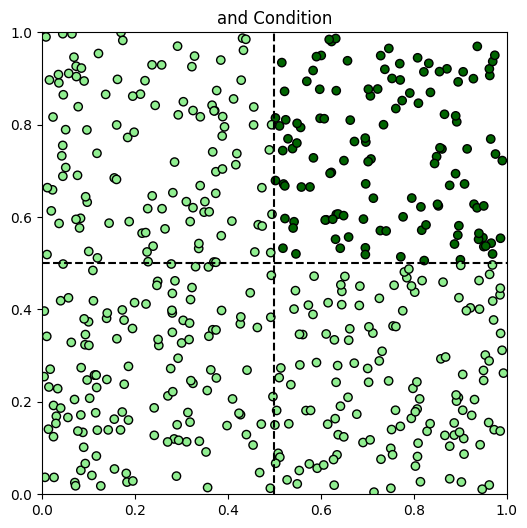

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [21, 26, 7, 22, 8, 25, 24, 11, 12, 9, 23, 10, 1, 16, 13, 27, 4, 3, 0, 2, 5, 6, 19, 15, 17, 20, 18, 14]


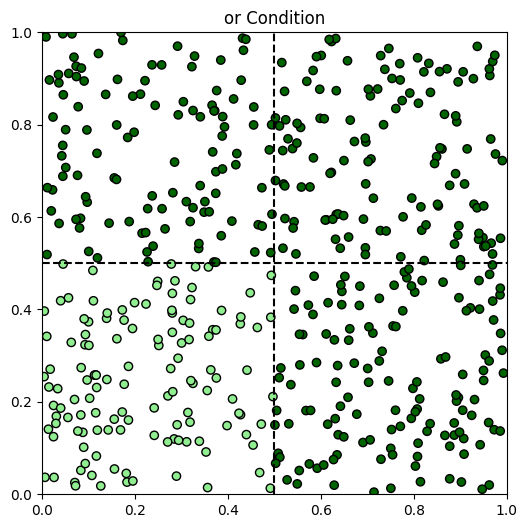

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [14, 25, 8, 4, 3, 6, 5, 17, 26, 16, 11, 21, 23, 20, 12, 10, 19, 0, 1, 22, 13, 2, 18, 7, 27, 9, 15, 24]


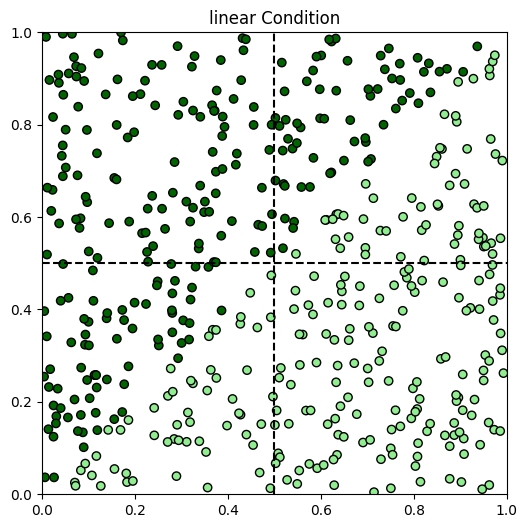

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [0, 25, 26, 27, 9, 19, 12, 3, 2, 1, 5, 11, 16, 14, 4, 10, 13, 6, 20, 21, 24, 23, 18, 22, 7, 15, 8, 17]


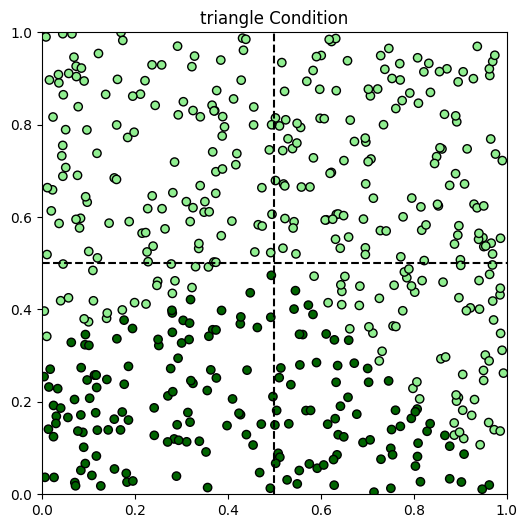

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [19, 22, 27, 25, 3, 1, 21, 7, 9, 20, 15, 17, 14, 11, 16, 2, 13, 6, 12, 26, 5, 0, 18, 8, 4, 23, 10, 24]


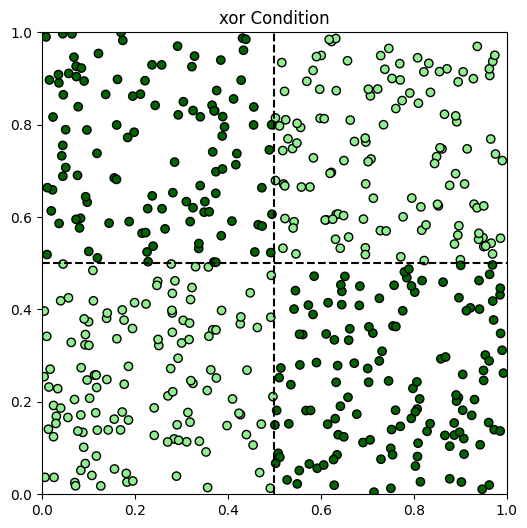

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [17, 15, 0, 9, 3, 27, 23, 24, 21, 1, 18, 26, 16, 10, 13, 7, 11, 5, 4, 22, 14, 2, 8, 12, 6, 25, 20, 19]


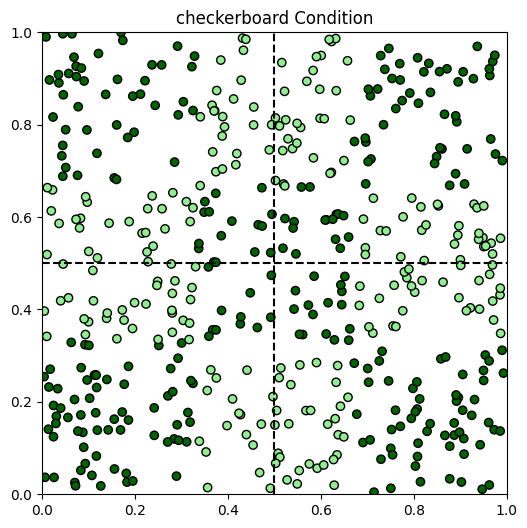

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [25, 13, 15, 12, 3, 14, 18, 27, 2, 1, 16, 0, 10, 23, 22, 20, 8, 6, 17, 26, 19, 24, 9, 5, 21, 7, 4, 11]


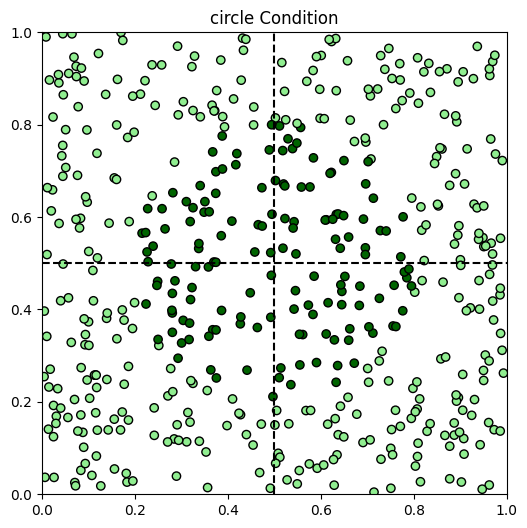

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [25, 9, 1, 10, 22, 19, 12, 2, 3, 11, 27, 20, 18, 0, 24, 14, 5, 13, 6, 15, 8, 7, 21, 26, 23, 16, 17, 4]


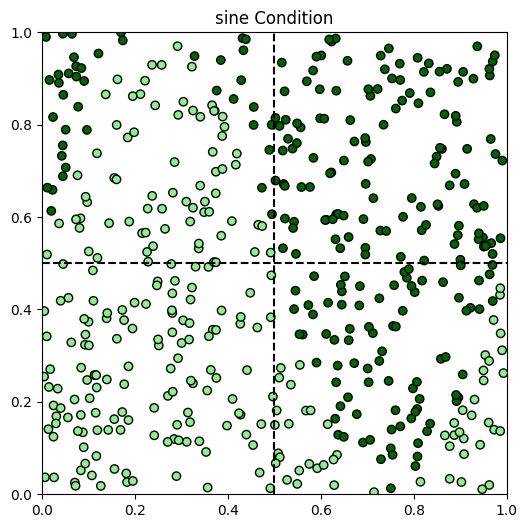

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [11, 17, 6, 27, 14, 20, 8, 10, 24, 9, 26, 5, 13, 0, 23, 1, 3, 19, 22, 21, 4, 18, 25, 16, 2, 12, 7, 15]


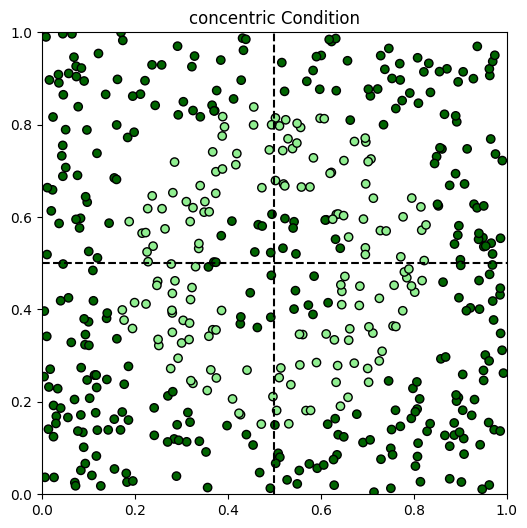

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [27, 8, 12, 15, 7, 23, 26, 16, 2, 5, 17, 20, 21, 22, 3, 24, 6, 11, 14, 13, 19, 10, 9, 1, 0, 4, 18, 25]


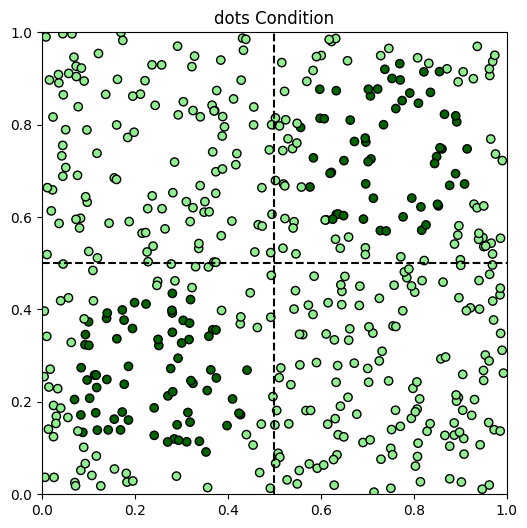

./Reservoir/iML1515EXP_train_AMN_QP
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [21, 16, 10, 20, 24, 12, 26, 25, 27, 19, 6, 3, 5, 23, 18, 0, 8, 1, 17, 2, 22, 9, 13, 14, 4, 7, 11, 15]


In [32]:
# Generating dataset

DIRECTORY = './'

from Library.Build_Model import Neural_Model
from Library.Utilities  import map_and_binarize_feature
from Library.Build_Dataset import get_minmed_varmed_ko

species = [ 
    'e_coli_core', #0
    'iEK1008', 
    'iIT341', #2
    'iJN1463', 
    'iML1515', #4
    'iMM904',
    'iPC815', #6
    'iYO844',
    'iYS1720', 
    'iYS854', # 9
    'iML1515EXP', #10
]

conditions = {
    "and": generate_and_condition,
    "or": generate_or_condition,
    "linear": generate_linear_condition,
    "triangle": generate_triangle_condition,
    "xor": generate_xor_condition,
    "checkerboard": generate_checkerboard,
    "circle": generate_circle_condition,
    "sine": generate_sine_wave_condition,
    "concentric": generate_concentric_condition,
    "dots": generate_two_dots_condition
}

x1, x2 = generate_random_points(n_points=500)
x = np.column_stack((x1, x2))
xr, xb = round_binarize_x(x[:,0], x[:,1], scaler=13)

for name, func in conditions.items():
    y_true = func(x[:,0], x[:,1])
    filename = f'{DIRECTORY}Dataset_input/Dataset_classification/{name.lower()}.csv'
    save_dataset(x, y_true, filename)
    x, y_true, y_pred = load_dataset(filename)
    plot_data(x[:,0], x[:,1], y_true, y_pred, f'{name} Condition')

    # Mapping with reservoir
    for i in [10]:
        s = species[i]
        reservoirname = f'{s}_train_AMN_QP'
        reservoirfile = f'{DIRECTORY}Reservoir/{reservoirname}'

        print(reservoirfile)
        
        reservoir = Neural_Model()
        reservoir.load(reservoirfile)
        
        # map and binarize the input
        xb = map_and_binarize_feature(xb, y_true, 
                                      reservoir.X, reservoir.Y, 
                                      threshold=0.5,
                                      regression=False, verbose=True)
        medium = reservoir.medium
        minmed, varmed, ko = get_minmed_varmed_ko(medium)    
        filename = f'{DIRECTORY}Dataset_input/Dataset_classification/{name.lower()}_{s}_binary.csv'
        save_dataset(xb, y_true, filename, header=list(varmed.keys()))


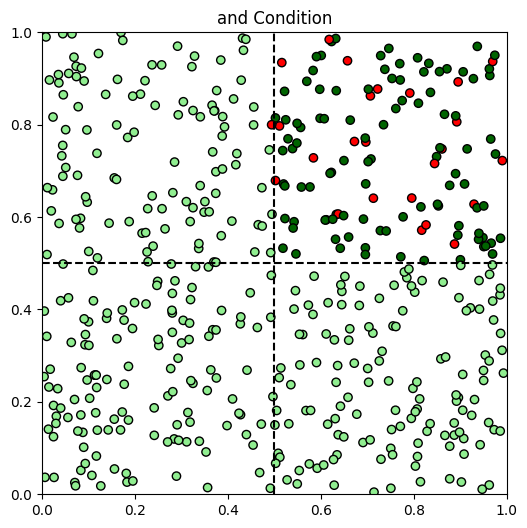

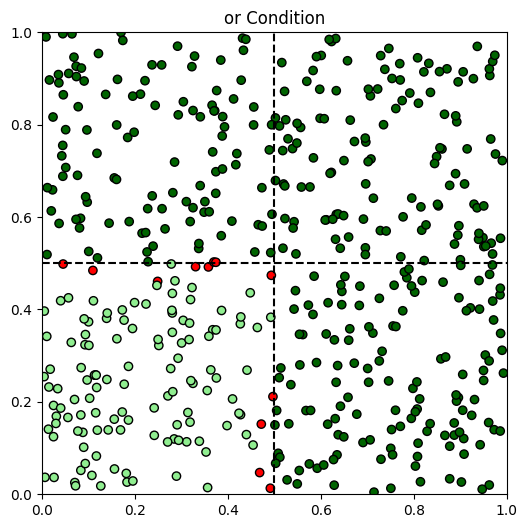

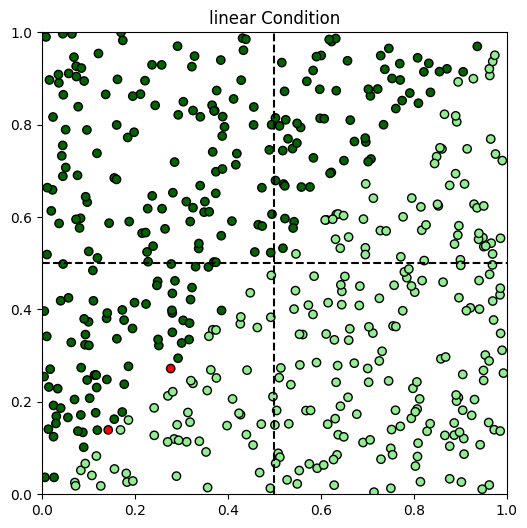

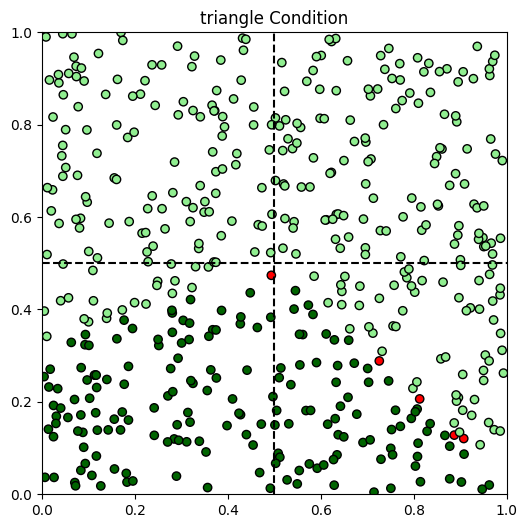

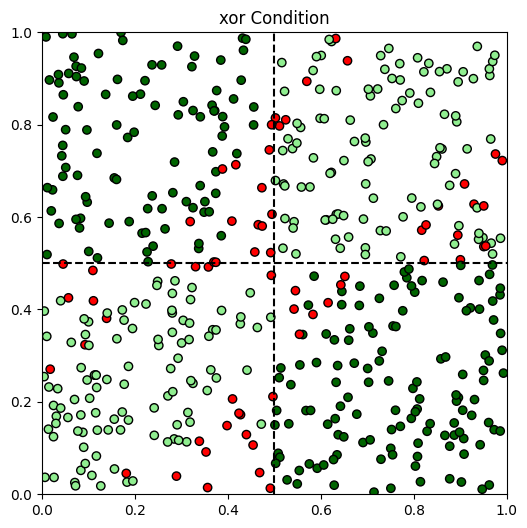

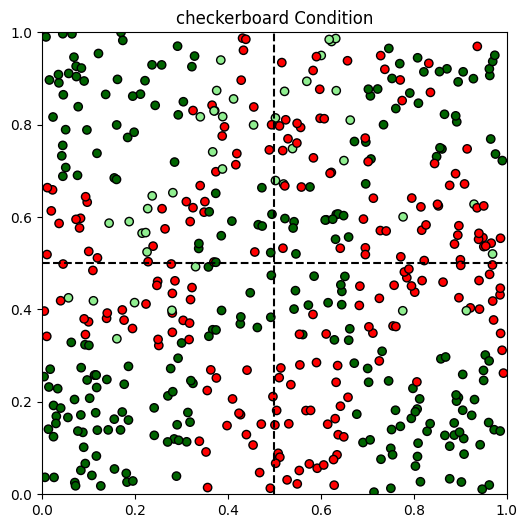

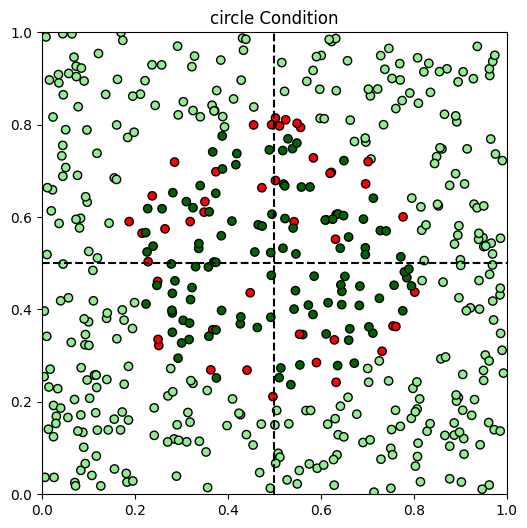

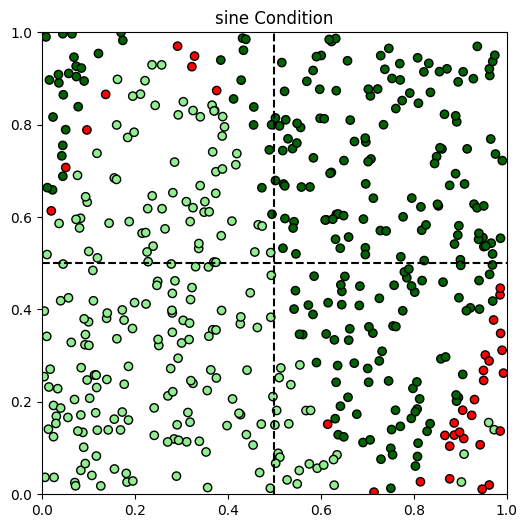

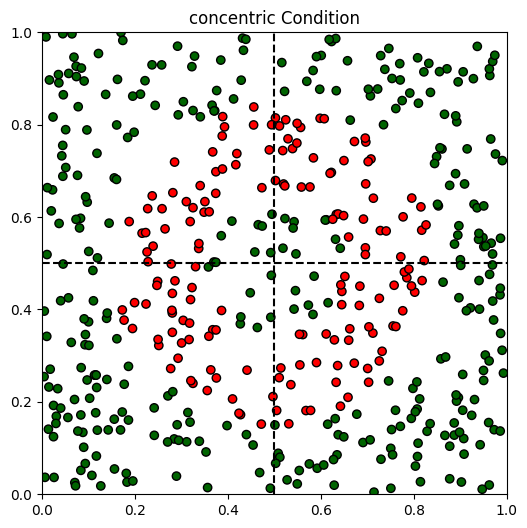

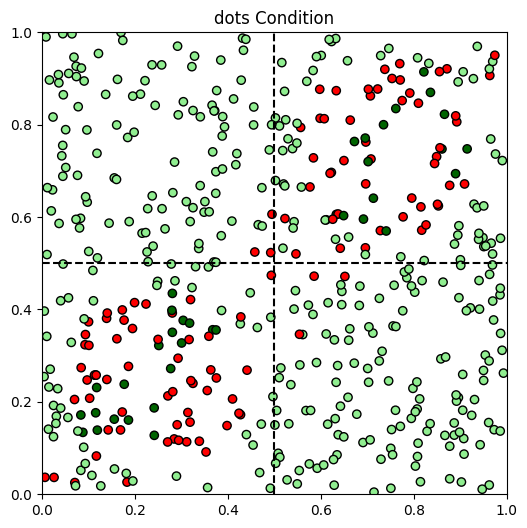

In [45]:
# plotting results

DIRECTORY = './'

from Library.Build_Model import Neural_Model
from Library.Utilities  import map_and_binarize_feature
from Library.Build_Dataset import get_minmed_varmed_ko

species = [ 
    'e_coli_core', #0
    'iEK1008', 
    'iIT341', #2
    'iJN1463', 
    'iML1515', #4
    'iMM904',
    'iPC815', #6
    'iYO844',
    'iYS1720', 
    'iYS854', # 9
    'iML1515EXP', #10
]

conditions = {
    "and": generate_and_condition,
    "or": generate_or_condition,
    "linear": generate_linear_condition,
    "triangle": generate_triangle_condition,
    "xor": generate_xor_condition,
    "checkerboard": generate_checkerboard,
    "circle": generate_circle_condition,
    "sine": generate_sine_wave_condition,
    "concentric": generate_concentric_condition,
    "dots": generate_two_dots_condition
}

for name, func in conditions.items():
    filename = f'{DIRECTORY}Dataset_input/Dataset_classification/{name.lower()}_iML1515EXP_selective_obj.csv'
    x, y_true, y_pred = load_dataset(filename)
    plot_data(x[:,0], x[:,1], y_true, y_pred, f'{name} Condition')


# Find mapping for reservoir with regression problems

This notebook take an input dataset for regression problem and binarize the input to be fed to an AMN reservoir. The code make use of RandomForestRegressor to rank the features (feature_importance) and find the mapping to the reservoir input.

## Utilities

In [1]:
# Run this cell first 

def fixed_prior(reservoirfile, X, Y, mode='AMN-phenotype',
                       n_hidden_post=0,
                       train_rate=1.0e-3, batch_size=10, xfold=5, epochs=100, 
                       niter=1, t0=0.1, t1=1, dt=0.1, verbose=False):
    # Search best threshold for binarizer on binarized input

    from Library.Utilities  import map_and_binarize_feature
    from Library.Build_Reservoir import RC_Model
    from Library.Build_Model import train_evaluate_model, evaluate_model, model_input
    from sklearn.metrics import r2_score, accuracy_score

    batch_size = 100 if X.shape[0] > 1000 else 10    
    best_t, best_r2, failure = -1, -1000, 10
     
    for t in np.arange(t0, t1, dt):
        # Create model
        model = RC_Model(mode=mode,
                reservoirfile=reservoirfile, X=X, Y=Y,
                n_hidden_prior=-1, n_hidden_post=n_hidden_post,
                activation_post='relu',
                batch_size=batch_size,
                epochs=epochs, train_rate=train_rate, 
                xfold=xfold, niter=niter, verbose=verbose)
        
        # map and binarize the input
        model.X = map_and_binarize_feature(model.X, model.Y, 
                                           model.res.X, model.res.Y, 
                                           threshold=t, verbose=verbose)

        
        # Train and evaluate
        _, pred, _, _ = train_evaluate_model(model, failure=failure, verbose=verbose)
        r2 = r2_score(Y, pred[:, 0], multioutput='variance_weighted')
        if verbose:
            print(f'threshold: {t:.2f} q2: {r2:.3f}')
        if r2 > best_r2:
            best_r2 = r2
            best_t = t
            best_model = model
    if verbose:
        print(f'Best threshold: {best_t:.2f} q2: {best_r2:.3f}')
    
    return best_model, best_t, best_r2

def write_model_fixed_prior(trainingfile, model, verbose=True):  
    # Write file with X in binary format
    from Library.Build_Dataset import get_minmed_varmed_ko
    from Library.Utilities import write_csv
    
    medium = model.res.medium
    minmed, varmed, ko = get_minmed_varmed_ko(medium)    
    medium = list(varmed.keys())
    medium.append('Y_true')
    H = np.asarray(medium)
    D = np.concatenate((model.X, model.Y), axis=1)
    write_csv(trainingfile, H, D)

## Main code

In [2]:
# Search the best mapping between an input file and reservoir input

from Library.Import import *
from Library.Utilities  import read_XY

DIRECTORY = './'
problems = [
    'raw_geographical_origin_of_music', # 0
    'raw_pumadyn32nh',
    'raw_white_wine', # 2
    'raw_kin8nm',
    'raw_cars', # 4
    'raw_airfoil_self_noise', #5
    'raw_QSAR_fish_toxicity', # 6
    'raw_space_ga',
    'raw_concrete_compressive_strength', # 8
    'raw_grid_stability',
    'raw_miami_housing', # 10
    'raw_cpu_activity', # 11
    'raw_naval_propulsion_plant',
    'raw_energy_efficiency' # 13
]

species = [ 
    'e_coli_core', #0
    'iEK1008', 
    'iIT341', #2
    'iJN1463', 
    'iML1515', #4
    'iMM904',
    'iPC815', #6
    'iYO844',
    'iYS1720', 
    'iYS854', # 9
    'iML1515EXP', #10
]

seed = 10
np.random.seed(seed=seed)
mode = 'AMN_phenotype'
precision = 0
n_hidden_post = 0 
xfold = 5
epochs = 100 
niter = 1 # 0 for full xfold cv
train_rate = 1.0e-4 # 1.0e-4 for white wine may be 1.0e-3 otherwise

for i in [10]: # list(range(11))
    s = species[i]
    reservoirname = f'{s}_train_AMN_QP'
    reservoirfile = f'{DIRECTORY}Reservoir/{reservoirname}' 
    for j in [8]: # [2, 3, 4, 5, 6, 7, 8, 9, 11, 13]: # list(range(14)):
        problem = problems[j].split('.')[0]
        trainingfile = f'{DIRECTORY}Dataset_input/Dataset_open_ML/Regression/{problem}'
        resultfile = f'{DIRECTORY}Result/{problem}_{s}_{mode}_{str(precision)}'
        H, X, Y = read_XY(trainingfile, nY=1, scaling='XY')
        start_time = time.time()
        # search treshold between 0.1 and 0.9
        t0, t1, dt = 0.1, 1.0, 0.1
        model, threshold, q2 = fixed_prior(reservoirfile, X, Y, mode=mode,
                            n_hidden_post=n_hidden_post,
                            train_rate=train_rate, 
                            xfold=xfold, epochs=epochs, niter=niter, 
                            t0=t0, t1=t1, dt=dt, verbose=True)
        # search around the threshold
        t0, t1, dt = threshold-0.01, threshold+0.02, 0.01
        model, threshold, q2 = fixed_prior(reservoirfile, X, Y, mode=mode,
                            n_hidden_post=n_hidden_post,
                            train_rate=train_rate, 
                            xfold=xfold, epochs=epochs, niter=niter, 
                            t0=t0, t1=t1, dt=dt, verbose=True)
        delta_time = time.time() - start_time
        print(f'{problem} {s} Threshold {threshold:.2f} Q2: {q2:.3f} cpu time {delta_time:.2f}')
        trainingfile = f'{trainingfile}_{s}_binary' 
        write_model_fixed_prior(trainingfile, model, verbose=True)
        

number of reactions: 3682=1
number of metabolites: 1877
filtered measurements size: 1
reservoir: [0, 1, 2, 12, 22, 10, 18, 15, 19, 7, 13, 9, 14, 8, 24, 27, 25, 23, 26, 4, 16, 17, 3, 21, 6, 20, 5, 11]
problem  : [7, 2, 6, 5, 25, 14, 18, 9, 22, 4, 3, 13, 1, 8, 12, 21, 26, 11, 16, 17, 23, 27, 10, 24, 15, 20, 0, 19]
RC scaler: MinMaxScaler()
RC input shape:((1030, 28), (1030, 1))
-------train (824, 28) (824, 2)
-------test  (206, 28) (206, 2)
----------------------------------- RC
Prior IO (None, 28)  (None, 28)
Reservoir matrices shapes W (2,) bias (2,)
Res IO (None, 28) (None, 3682)
Dense layer n_hidden: 0 hidden_dim: 1 input_dim: 3682 output_dim: 1 activation: relu trainable: True
Post IO Scoring=r2_score (None, 3682) (None, 1) MinMax-Scaler: (0.0746, 1.0461)
7/7 [==============================] - 0s 3ms/step
train = 0.20 test = 0.24 loss-train = -1.000000 loss-test = -1.000000 Media found = 0 / 0
33/33 [==============================] - 0s 3ms/step
threshold: 0.10 q2: 0.213
number of r